Objective : Menurut Organisasi Kesehatan Dunia (WHO) stroke adalah penyebab kematian nomor dua secara global, bertanggung jawab atas sekitar 11% dari total kematian. Kumpulan data ini digunakan untuk memprediksi kemungkinan seorang pasien terkena stroke berdasarkan parameter input seperti jenis kelamin, usia, berbagai penyakit, dan status merokok. Setiap baris dalam data memberikan informasi yang relevan tentang pasien. Metrics yang saya gunakan untuk mengevaluasi kinerja model adalah recall karena saya ingin lebih memilih False Positif lebih baik terjadi daripada False Negatif. Dalam dataset ini, maka saya mempertimbangkan Recall karena lebih baik algoritma kita memprediksi pasien positif stroke tetapi sebenarnya tidak terkena stroke daripada algoritma salah memprediksi bahwa pasien diprediksi tidak terkena stroke padahal sebenarnya pasien tersebut mengidap sakit stroke.

# Import Libraries

In [115]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Library untuk feature engineering
from feature_engine.outliers import Winsorizer
from scipy import stats

# Library untuk split data
from sklearn.model_selection import train_test_split

# Library untuk pipeline
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTENC

# Library untuk modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score

# Library untuk cross validation
from sklearn.model_selection import cross_val_score

# Library untuk hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Library untuk model saving
import pickle

# Import library untuk mengabaikan peringatan
import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [2]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
# Duplicate Data
df = data.copy()

## Eksplorasi Data Sederhana

In [4]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


**PENJELASAN KOLOM:**

- `id`: pengidentifikasi unik
- `gender`: "Pria", "Wanita" atau "Lainnya"
- `age`: usia pasien
- `hypertension`: 0 jika pasien tidak menderita hipertensi, 1 jika pasien menderita hipertensi
- `heart_disease`: 0 jika pasien tidak memiliki penyakit jantung apa pun, 1 jika pasien memiliki penyakit jantung
- `ever_married`: "Tidak" atau "Ya"
- `work_type`: "anak-anak", "Pemerintah_jov", "Belum pernah bekerja", "Swasta" atau "Wiraswasta"
- `Residence_type`: "Pedesaan" atau "Perkotaan"
- `avg_glucose_level`: rata-rata kadar glukosa dalam darah
- `bmi`: indeks massa tubuh
- `smoking_status`: "sebelumnya merokok", "tidak pernah merokok", "merokok" atau "Tidak diketahui"*
- `stroke`: 1 jika pasien terkena stroke atau 0 jika tidak

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Statement:
- Pada dataset ini terdiri dari 12 kolom dengan masing-masing data terdiri dari float (3 kolom), integer (4 kolom), dan object (5 kolom).
- Terdapat missing values pada kolom `bmi`.
- Memory dataset sebesar 479.2 KB

In [6]:
# Menghapus kolom 'Unnamed: 0'
df = df.drop(columns= 'id')
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [7]:
# Cek duplicate data
df.duplicated().sum()

0

Tidak ada duplicate data.

In [8]:
# Cek missing values
missing_values = df.isnull().sum()

# Menampilkan kolom yang terdapat missing values dan berapa banyak missing valuesnya
print("Nama kolom:")
print(missing_values[missing_values > 0])

# Cek persentase misisng values 'bmi'
persentase = df['bmi'].isnull().sum()/len(data)*100
print('Persentase missing values kolom price: ', persentase)

Nama kolom:
bmi    201
dtype: int64
Persentase missing values kolom price:  3.9334637964774952


In [9]:
# Rename column
df = df.rename(columns={"Residence_type": "residence_type"})

In [10]:
# Membuat variabel untuk function cek unique values
kolom = df[['gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status']]

In [11]:
# Cek unique values dari beberapa kolom

def val(x):
    for column in x.columns:
        print('{}:{},'.format(column,x[column].unique()))
        print('          ')

val(kolom)

gender:['Male' 'Female' 'Other'],
          
ever_married:['Yes' 'No'],
          
work_type:['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked'],
          
residence_type:['Urban' 'Rural'],
          
smoking_status:['formerly smoked' 'never smoked' 'smokes' 'Unknown'],
          


In [12]:
# Cek berapa banyak data dari setiap values
df['gender'].value_counts().unique()

array([2994, 2115,    1], dtype=int64)

Karena Other di dalam kolom `gender` hanya 1, jadi saya akan melakukan drop.

In [13]:
# Mengganti value 'Other' menjadi NaN kemudian di drop
df['gender'].replace('Other', np.nan, inplace=True)
df = df.dropna(subset=['gender']) 

In [14]:
# Cek unique values pada kolom smoking_status
df['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [15]:
# Mengisi missing values dalam kolom 'smoking_status' nilai-nilai sampel yang diambil secara acak dari kolom yang sama.

df['smoking_status'].replace('Unknown', np.nan, inplace=True)
column_values = df['smoking_status'].dropna() 
sampled_values = np.random.choice(column_values, size=df['smoking_status'].isnull().sum(), replace=True)
df.loc[df['smoking_status'].isnull(), 'smoking_status'] = sampled_values

In [16]:
# Cek kembali unique values dari kolom smoking_status
df['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes'], dtype=object)

In [17]:
df.shape

(5109, 11)

Pada dataset ini, jumlah baris sebanyak 5109 dan jumlah kolom sebanyak 11.

# Exploratory Data Analysis (EDA)

In [18]:
# Mengcopy dataframe df untuk proses EDA
df_eda = df.copy()

## 1. Bagaimana distribusi status stroke?

In [19]:
df_eda['stroke'] = df_eda['stroke'].replace({1: 'Yes', 0: 'No'})
stroke_counts = df_eda['stroke'].value_counts().reset_index()
stroke_counts.columns = ['Stroke', 'Count']
custom_colors = ['#4f5bd5', '#d62976'] 
fig = px.pie(stroke_counts, names='Stroke', values='Count',
             title='Distribusi Status Stroke',
             color_discrete_sequence=custom_colors,
             hole=0.3
             )

fig.show()

In [20]:
df_eda['stroke'].value_counts()

No     4860
Yes     249
Name: stroke, dtype: int64

**INSIGHT:**

Berdasarkan pie chart di atas, dapat dilihat distribusi kasus stroke dalam dataset yang secara efektif mengkategorikan menjadi kategori "Stroke" dan "Tidak Stroke". Terdapat ketidakseimbangan kelas dalam dataset, dengan jumlah orang yang tidak stroke lebih besar dibandingkan orang yang stroke. Total orang yang tidak stroke adalah sebesar 4861 sedangkan orang yang mengalami stroke sebanyak 249. Namun, diagram ini secara utama hanya menggambarkan distribusi kasus stroke dan mungkin tidak memberikan wawasan yang lebih dalam tentang faktor-faktor lainnya.

## 2. Apakah usia pasien berhubungan dengan risiko stroke?

In [21]:
age_stroke_counts = df_eda.groupby(["age", "stroke"]).size().reset_index(name="Count")

fig = px.scatter(age_stroke_counts, x="age", y="Count", size="Count", color="stroke",
                                   title="Distribusi Stroke pada Kelompok Umur",
                                   labels={"age": "Age", "Count": "Count", "stroke": "Stroke"},
                                   color_discrete_sequence=custom_colors,
                                    width=1000, height=400)

fig.update_layout(xaxis_title="Age", yaxis_title="Jumlah")
fig.show()

**INSIGHT:**

Berdasarkan visualisasi di atas, dapat dilihat bahwa risiko stroke cenderung meningkat seiring bertambahnya usia, dimana kasus stroke yang lebih banyak terjadi pada populasi lansia.

## 3. Apakah ada hubungan antara BMI dengan kemungkinan terkena stroke?

In [22]:
# Cek nilai minimum dan maksimum dari kolom bmi
print(df_eda['bmi'].min())
print(df_eda['bmi'].max())

10.3
97.6


In [23]:
# Membuat group bmi menjadi 7 group
df_eda['bmi_kat'] = pd.cut(df_eda['bmi'], 
                       bins=[10, 18.5, 24.9, 29.9, 34.9, 39.9, 50, float('inf')], 
                       labels=['Underweight', 'Normal', 'Overweight', 'Obese Class I', 'Obese Class II', 'Obese Class III' , 'Extreme Obesity'])

print(df_eda[['bmi', 'bmi_kat']].head())

    bmi         bmi_kat
0  36.6  Obese Class II
1   NaN             NaN
2  32.5   Obese Class I
3  34.4   Obese Class I
4  24.0          Normal


In [24]:
bmi_stroke_counts = df_eda.groupby(['bmi_kat', 'stroke']).size().reset_index(name='Count')
fig = px.bar(bmi_stroke_counts, x='bmi_kat', y='Count', color='stroke',
             title='Distribusi Stroke Berdasarkan BMI Kategori',
             labels={'bmi_kat': 'BMI Kategori', 'Count': 'Count', 'stroke': 'Stroke'},
             color_discrete_sequence = custom_colors )
fig.update_layout(xaxis_title='BMI Kategori', yaxis_title='Jumlah', legend_title='Stroke')
fig.show()

**INSIGHT:**

Berdasarkan visualisasi di atas, dapat dilihat bahwa tidak ada korelasi yang signifikan antara BMI dan terjadinya stroke. Jika BMI memiliki hubungan dengan terjadinya stroke maka seharusnya orang-orang yang Extreme Obesity akan lebih mudah terkena stroke, nyatanya dalam visualiasi di atas tidak begitu. Jadi stroke dapat terjadi di berbagai nilai BMI.

## 4. Bagaimana distribusi status merokok?

In [25]:
smoking_status_counts = df_eda['smoking_status'].value_counts().reset_index()
smoking_status_counts.columns = ['smoking_status', 'Jumlah']
custom_colors_4 = ['#131862', '#546bab', '#87889c', '#bea9de']

fig = px.bar(
    smoking_status_counts, 
    x='smoking_status', 
    y='Jumlah', 
    title='Distribusi Status Merokok',
    color='smoking_status',  
    color_discrete_sequence = custom_colors_4
)

fig.show()

**INSIGHT:**

Berdasarkan visualisasi di atas, kita dapat melihat bahwa sebagian besar individu termasuk dalam kategori "tidak pernah merokok," diikuti oleh "pernah merokok" dan "merokok."

## 5. Bagaimana perbedaan rata-rata kadar gula darah (glucose) antara individu yang stroke dan yang tidak?

In [26]:
# Cek nilai minimum dan maksimum dari kolom avg_glucose_level
print(df_eda['avg_glucose_level'].min())
print(df_eda['avg_glucose_level'].max())

55.12
271.74


In [27]:
# Membuat group avg_glucose_level menjadi 4 group
df_eda['glucose_group'] = pd.cut(df_eda['avg_glucose_level'], 
                             bins=[55.12, 70, 99, 125, float('inf')], 
                             labels=['Low', 'Normal', 'Pre-Diabetes', 'Diabetes'])

print(df_eda[['avg_glucose_level', 'glucose_group']].head())

   avg_glucose_level glucose_group
0             228.69      Diabetes
1             202.21      Diabetes
2             105.92  Pre-Diabetes
3             171.23      Diabetes
4             174.12      Diabetes


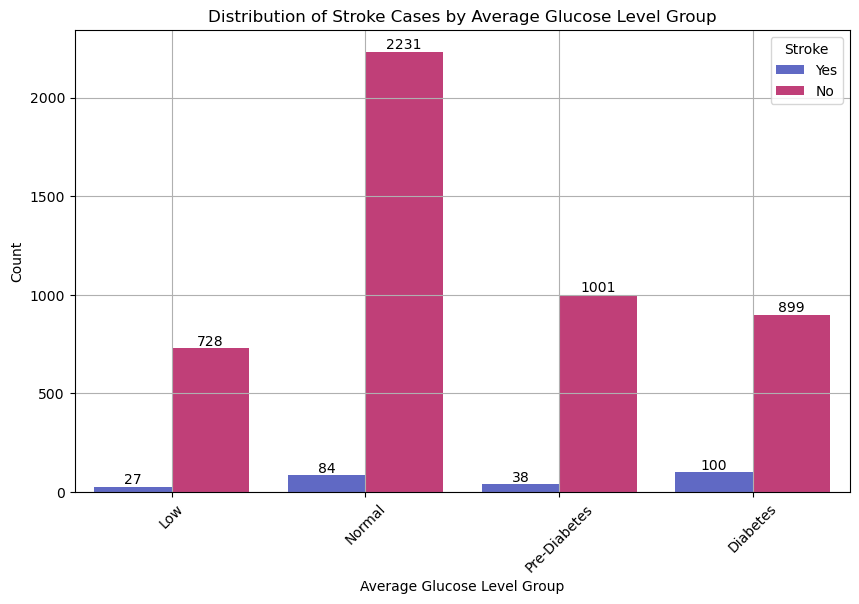

In [28]:
custom_palette = custom_colors
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_eda, x='glucose_group', hue='stroke', palette=custom_palette)
plt.title("Distribution of Stroke Cases by Average Glucose Level Group")
plt.xlabel("Average Glucose Level Group")
plt.ylabel("Count")
for n in ax.patches:
    height = n.get_height()
    ax.annotate(f"{int(height)}", (n.get_x() + n.get_width() / 2., height), ha='center', va='bottom')
plt.legend(title="Stroke", labels=["Yes", "No"])
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**INSIGHT:**


Berdasarkan visualiasi di atas, kita dapat melihat bahwa individu yang memiliki diabetes cenderung memiliki risiko stroke tertinggi, sementara individu dengan rata-rata kadar gula darah rendah memiliki risiko paling rendah.

# Feature Engineering

## Cardinality Analysis

In [29]:
df_cat = df.loc[:,['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status']]
df_cat.head()

,gender,hypertension,heart_disease,ever_married,work_type,residence_type,smoking_status
0,Male,0,1,Yes,Private,Urban,formerly smoked
1,Female,0,0,Yes,Self-employed,Rural,never smoked
2,Male,0,1,Yes,Private,Rural,never smoked
3,Female,0,0,Yes,Private,Urban,smokes
4,Female,1,0,Yes,Self-employed,Rural,never smoked


In [30]:
print('Number of categories in the variable gender              : {}'.format(len(df_cat.gender.unique())))
print('Number of categories in the variable hypertension        : {}'.format(len(df_cat.hypertension.unique())))
print('Number of categories in the variable heart_disease       : {}'.format(len(df_cat.heart_disease.unique())))
print('Number of categories in the variable ever_married        : {}'.format(len(df_cat.ever_married.unique())))
print('Number of categories in the variable work_type           : {}'.format(len(df_cat.work_type.unique())))
print('Number of categories in the variable residence_type      : {}'.format(len(df_cat.residence_type.unique())))
print('Number of categories in the variable smoking_status      : {}'.format(len(df_cat.smoking_status.unique())))
print('Total                                                    : {}'.format(len(df)))

Number of categories in the variable gender              : 2
Number of categories in the variable hypertension        : 2
Number of categories in the variable heart_disease       : 2
Number of categories in the variable ever_married        : 2
Number of categories in the variable work_type           : 5
Number of categories in the variable residence_type      : 2
Number of categories in the variable smoking_status      : 3
Total                                                    : 5109


**INSIGHT:**

Dapat dilihat bahwa number of categories (unique value) dari `gender`, `hypertension`, `heart_disease`, `ever_married`, `work_type`, `residence_type`, dan `smoking_status` tidak ada high cardinality.

## Handling Outlier

In [31]:
num_cols = df[['age', 'avg_glucose_level', 'bmi']]

In [32]:
# Memeriksa distribusi data

num_normal = []
num_tidak_normal = []
    
for i in num_cols:
    skewness = num_cols[i].skew()
    
    if (skewness >=0.5) | (skewness <=-0.5):
        num_tidak_normal.append(i)

    elif (skewness<0.5) & (skewness >=-0.5):
        num_normal.append(i)
    
    print(f"Skewness dari {i} adalah {skewness}")

Skewness dari age adalah -0.13743019262921288
Skewness dari avg_glucose_level adalah 1.5728153284961561
Skewness dari bmi adalah 1.0550629490426457


In [33]:
# Melihat list kolom data yang berdistribusi normal dan tidak normal

print(f'Data numerik yang normal: {num_normal}')
print(f'Data numerik yang tidak normal: {num_tidak_normal}')

Data numerik yang normal: ['age']
Data numerik yang tidak normal: ['avg_glucose_level', 'bmi']


### Distribusi Normal

Dapat dilihat dari hasil di atas, data numerik yang memiliki distribusi normal adalah kolom `age` dan kita bisa melakukan capping dengan metode gausian.

In [34]:
# Handling outlier dengan menggunakan metode caping gaussian

cap_normal = Winsorizer(capping_method='gaussian',
                             tail='both',
                             fold=3,
                             variables= num_normal)

cap_normal = cap_normal.fit_transform(num_cols[num_normal])

In [35]:
# Membuat fucntion untuk membuat histogram dan boxplot

def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

age


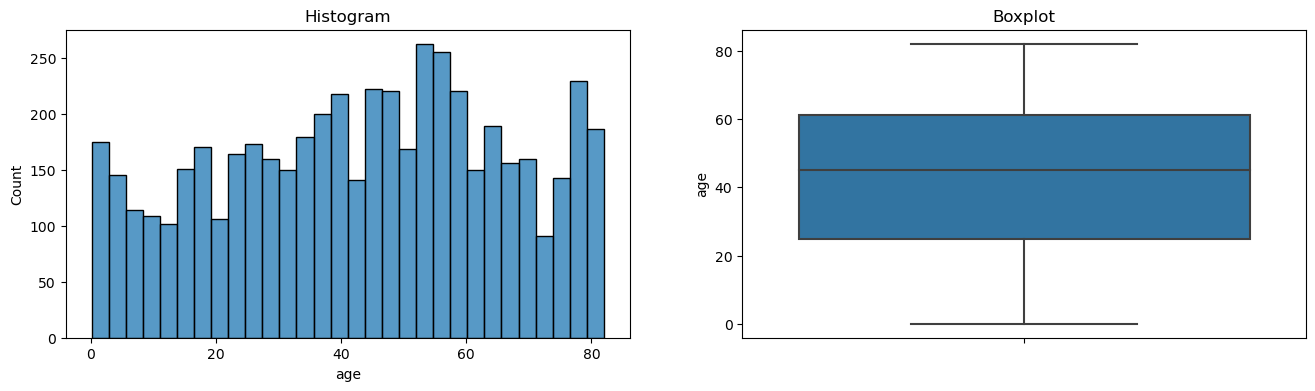

In [36]:
# Untuk memeriksa apakah ada outlier nya

print('age')
diagnostic_plots(cap_normal, 'age')

### Distribusi Tidak Normal (Skewed)

Dapat dilihat dari hasil di atas, data numerik yang memiliki distribusi tidak normal (skewed) adalah kolom `avg_glucose_level` dan `bmi` sehingga kita bisa melakukan capping dengan metode iqr.

In [37]:
# Handling outlier dengan menggunakan metode caping iqr

cap_tidak_normal = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=1.5,
                             variables=num_tidak_normal,
                             missing_values='ignore')

cap_tidak_normal = cap_tidak_normal.fit_transform(num_cols[num_tidak_normal])

avg_glucose_level - sebelum capping


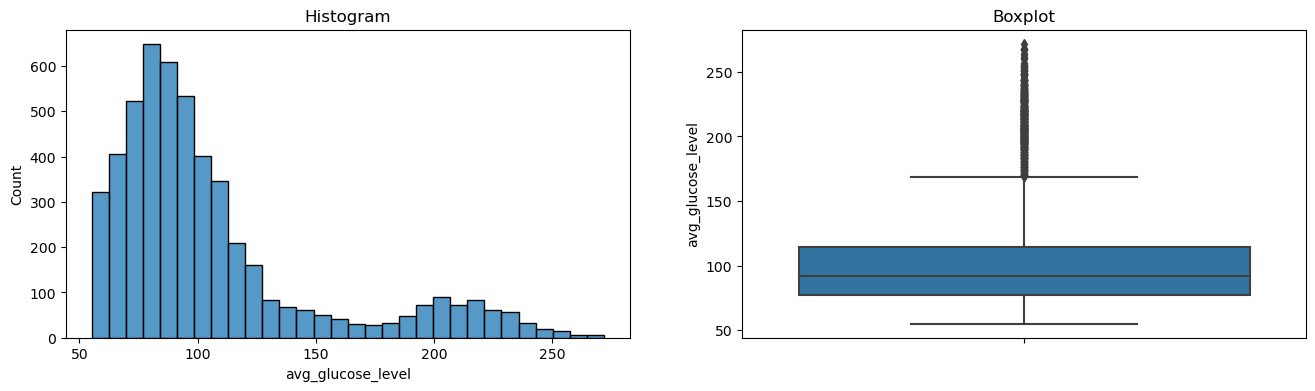

avg_glucose_level - sesudah capping


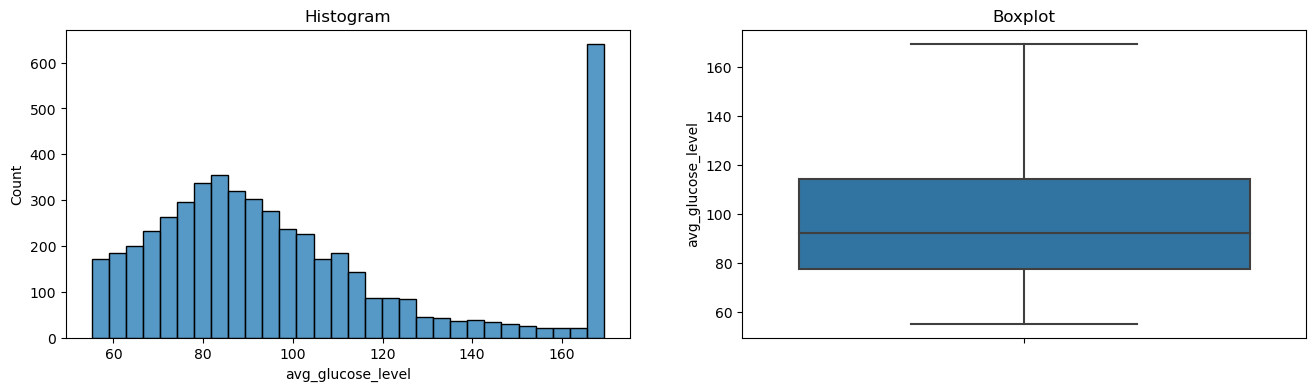

bmi - sebelum capping


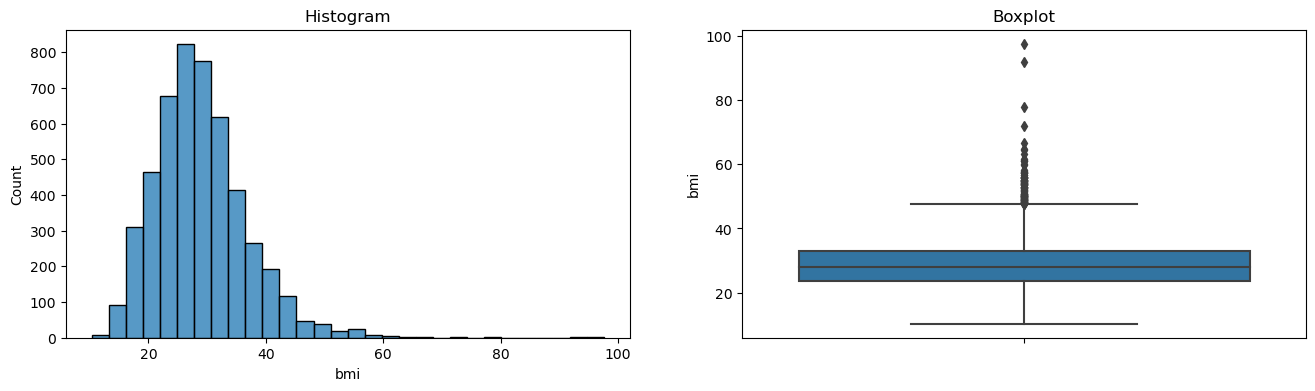

bmi - sebelum capping


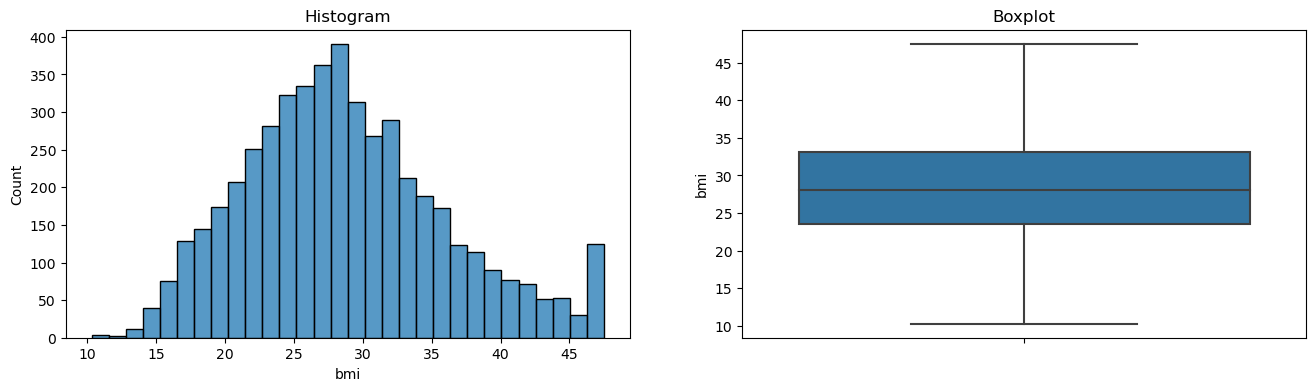

In [38]:
# Untuk memeriksa distribusi sebelum dan sesudah capping

print('avg_glucose_level - sebelum capping')
diagnostic_plots(num_cols, 'avg_glucose_level')

print('avg_glucose_level - sesudah capping')
diagnostic_plots(cap_tidak_normal, 'avg_glucose_level')

print('bmi - sebelum capping')
diagnostic_plots(num_cols, 'bmi')

print('bmi - sebelum capping')
diagnostic_plots(cap_tidak_normal, 'bmi')

In [39]:
cat_cols = df[['gender', 'hypertension','heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status', 'stroke']]

In [40]:
# Menggabungkan kolom kategorikal dan data setelah capping

concat_df = pd.concat([cap_normal, cap_tidak_normal, cat_cols],axis = 1)
concat_df

,age,avg_glucose_level,bmi,gender,hypertension,heart_disease,ever_married,work_type,residence_type,smoking_status,stroke
0,67.0,169.365,36.6,Male,0,1,Yes,Private,Urban,formerly smoked,1
1,61.0,169.365,NaN,Female,0,0,Yes,Self-employed,Rural,never smoked,1
2,80.0,105.920,32.5,Male,0,1,Yes,Private,Rural,never smoked,1
3,49.0,169.365,34.4,Female,0,0,Yes,Private,Urban,smokes,1
4,79.0,169.365,24.0,Female,1,0,Yes,Self-employed,Rural,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,83.750,NaN,Female,1,0,Yes,Private,Urban,never smoked,0
5106,81.0,125.200,40.0,Female,0,0,Yes,Self-employed,Urban,never smoked,0
5107,35.0,82.990,30.6,Female,0,0,Yes,Self-employed,Rural,never smoked,0
5108,51.0,166.290,25.6,Male,0,0,Yes,Private,Rural,formerly smoked,0


## Handling Missing Value

In [41]:
# Cek missing values

concat_df.isnull().sum()

age                    0
avg_glucose_level      0
bmi                  201
gender                 0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
smoking_status         0
stroke                 0
dtype: int64

## Feature Selection

Dalam proses Feature Selection, data dibagi menjadi numerical dan categorical. 
- Numerical data berisi feature: `age`, `avg_glucose_level`, `bmi`
- Categorical data berisi feature : `gender`, `hypertension`, `heart_disease`, `ever_married`, `work_type`, `residence_type`, `smoking_status`

Setelah dilakukan pembagian kelompok, baru dilakukan uji korelasi (menggunakan Pearson untuk numerical data dan Kendall untuk categorical data) dengan target yaitu 'default_payment' sehingga dapat mengetahui feature mana aja yang memiliki korelasi dan bisa menjadi bahan pertimbangan untuk dipilih.

### Numerical Data

In [42]:
numerical_cols = concat_df[['age', 'avg_glucose_level', 'bmi', 'stroke']]

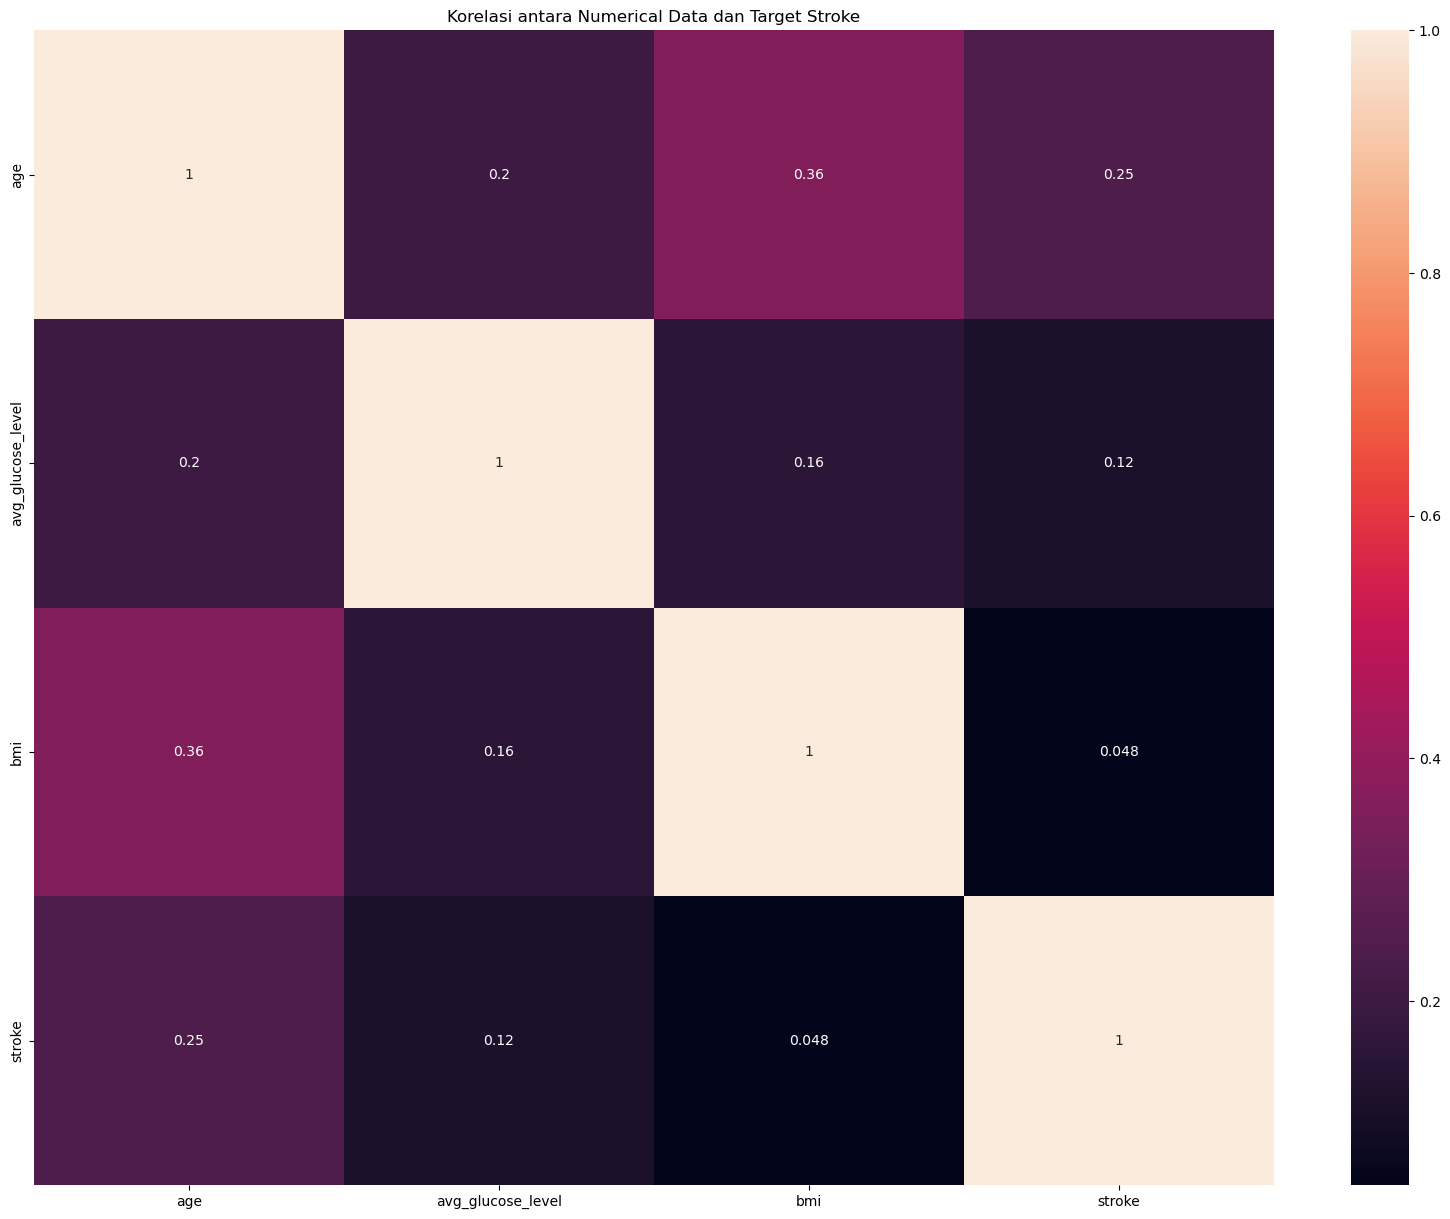

In [43]:
plt.figure(figsize=(20,15))
sns.heatmap(numerical_cols.corr(method='pearson'),annot=True)
plt.title('Korelasi antara Numerical Data dan Target Stroke')
plt.show()

**INSIGHT:**

Berdasarkan visualisasi heatmap di atas, dapat dilihat bahwa `age` dan `avg_glucose_level` memiliki kolerasi dengan target `stroke` sehingga kolom tersebut akan dimasukkan ke dalam feature. Sedangkan `bmi` memiliki korelasi yang kecil dengan target, tetapi saya tetap menggunakan kolom `bmi` karena menurut saya semakin tinggi bmi maka semakin tinggi risiko terkena stroke.

### Categorical Data

In [44]:
cat_cols = concat_df[['gender', 'hypertension','heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status', 'stroke']]
cat_cols.head()

,gender,hypertension,heart_disease,ever_married,work_type,residence_type,smoking_status,stroke
0,Male,0,1,Yes,Private,Urban,formerly smoked,1
1,Female,0,0,Yes,Self-employed,Rural,never smoked,1
2,Male,0,1,Yes,Private,Rural,never smoked,1
3,Female,0,0,Yes,Private,Urban,smokes,1
4,Female,1,0,Yes,Self-employed,Rural,never smoked,1


In [45]:
nilai = []

for kolom in cat_cols:
    kendall_corr, p_value = stats.kendalltau(concat_df['stroke'], concat_df[kolom])
    nilai.append((kolom, kendall_corr, p_value))

for i in nilai:
    kolom, kendall_corr, p_value = i
    print(f'{kolom}: \nKorelasi Kendall: {kendall_corr}\nP-value: {p_value}\n')

gender: 
Korelasi Kendall: 0.009080600160079338
P-value: 0.5163429153984674

hypertension: 
Korelasi Kendall: 0.12789125912919302
P-value: 6.220836512771849e-20

heart_disease: 
Korelasi Kendall: 0.1349048418004286
P-value: 5.330519571096404e-22

ever_married: 
Korelasi Kendall: 0.10829931566075396
P-value: 9.927482539666366e-15

work_type: 
Korelasi Kendall: -0.023078015025647595
P-value: 0.07793937989781394

residence_type: 
Korelasi Kendall: 0.01541458421031582
P-value: 0.27059883605831103

smoking_status: 
Korelasi Kendall: -0.03459166295786148
P-value: 0.009310903180673142

stroke: 
Korelasi Kendall: 1.0
P-value: 0.0



**INSIGHT:**

Berdasarkan hasil perhitungan korelasi menggunakan kendall, `hypertension`, `heart_disease`, dan `ever_married` memiliki korelasi positif yang signifikan dengan target 'stroke'. Sedangkan `gender`, `work_type`, `residence_type`, dan `smoking_status` memiliki korelasi Kendall yang tidak signifikan dengan variabel target 'stroke', yang berarti tidak ada hubungan yang signifikan.

In [46]:
# Membuat variabel baru sebagai feature selection

korelasi_num = concat_df[['age', 'avg_glucose_level', 'bmi']]
korelasi_cat = concat_df[['hypertension','heart_disease', 'ever_married']]

In [47]:
# Menggabungkan korelasi_num dan korelasi_cat

df_select = pd.concat([korelasi_num, korelasi_cat, concat_df['stroke']],axis = 1)
df_select

,age,avg_glucose_level,bmi,hypertension,heart_disease,ever_married,stroke
0,67.0,169.365,36.6,0,1,Yes,1
1,61.0,169.365,NaN,0,0,Yes,1
2,80.0,105.920,32.5,0,1,Yes,1
3,49.0,169.365,34.4,0,0,Yes,1
4,79.0,169.365,24.0,1,0,Yes,1
...,...,...,...,...,...,...,...
5105,80.0,83.750,NaN,1,0,Yes,0
5106,81.0,125.200,40.0,0,0,Yes,0
5107,35.0,82.990,30.6,0,0,Yes,0
5108,51.0,166.290,25.6,0,0,Yes,0


## Split Data

### Split Between X (Features) and y (Target)

In [48]:
# Memisahkan antara X dan y

X = df_select.drop(['stroke'], axis = 1)
y = df_select['stroke']
y

0       1
1       1
2       1
3       1
4       1
       ..
5105    0
5106    0
5107    0
5108    0
5109    0
Name: stroke, Length: 5109, dtype: int64

### Split Between Train-set and Test-set

In [49]:
# Memisahkan antara data train dan data test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 20, stratify=y)

print('Train size', X_train.shape)
print('Test size', X_test.shape)
print('Test size', y_test.shape)
print('Test size', y_test.shape)
X_train

Train size (3576, 6)
Test size (1533, 6)
Test size (1533,)
Test size (1533,)


,age,avg_glucose_level,bmi,hypertension,heart_disease,ever_married
2480,14.0,112.220,26.9,0,0,No
2637,78.0,169.365,23.5,0,1,Yes
2899,55.0,68.790,27.0,0,0,Yes
3670,51.0,92.950,23.9,0,0,Yes
2932,37.0,60.050,24.1,0,0,Yes
...,...,...,...,...,...,...
838,40.0,119.520,34.6,0,0,Yes
5059,61.0,120.230,22.7,0,0,Yes
4261,25.0,169.365,23.5,0,0,No
3014,55.0,169.365,40.4,1,0,Yes


## Pipeline

In [52]:
# Tentukan kolom numerik dan kategorikal
numeric_features = ['age', 'avg_glucose_level', 'bmi']
categorical_features = ['hypertension', 'heart_disease', 'ever_married']

# Pipeline untuk data numerik
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Pipeline untuk data kategorikal
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Gabungkan dua transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Pipeline untuk imbalance handling
smote = SMOTENC(sampling_strategy = 'auto', random_state = 20, categorical_features = [3,4,5])

# Pipeline untuk model KNN
pipe_knn = Pipeline(steps=[
    ('prep', preprocessor),
    ('smote', smote), 
    ('classifier', KNeighborsClassifier())    
])

# Pipeline untuk model SVC
pipe_svc = Pipeline(steps=[
    ('prep', preprocessor),
    ('smote', smote), 
    ('classifier', SVC())
])

# Pipeline untuk model Decision Tree
pipe_dt = Pipeline(steps=[
    ('prep', preprocessor),
    ('smote', smote),
    ('classifier', DecisionTreeClassifier())
])

# Pipeline untuk model Random Forest
pipe_rf = Pipeline(steps=[
    ('prep', preprocessor),
    ('smote', smote),
    ('classifier', RandomForestClassifier())
])

# Pipeline untuk model Ada Boost
pipe_ada = Pipeline(steps=[
    ('prep', preprocessor),
    ('smote', smote),
    ('classifier', AdaBoostClassifier())
])

# Baseline Model

## KNN

In [53]:
pipe_knn

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hypertension',
                                                   'heart_disease',
                                                   'ever_married'])])),
                ('smote',
                 SMOTENC(categorical_features=[3, 4, 5], random_state=20)),
                ('classifier', KNeighborsClassifier())])

In [54]:
# Melatih model KNN
pipe_knn.fit(X_train, y_train)
print('Training Score:  ', round(pipe_knn.score(X_train,y_train),4))
print('Testing Score:  ', round(pipe_knn.score(X_test,y_test),4))

Training Score:   0.8649
Testing Score:   0.7991


In [55]:
# Melakukan prediksi menggunakan model KNN
y_train_predict_knn = pipe_knn.predict(X_train)
y_test_predict_knn = pipe_knn.predict(X_test)

In [56]:
# Menampilkan laporan klasifikasi model KNN
print('------Clasification Report KNN Train-------')
print(classification_report(y_train,y_train_predict_knn))

print('')
print('------Clasification Report KNN Test-------')
print(classification_report(y_test,y_test_predict_knn))


------Clasification Report KNN Train-------
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      3402
           1       0.26      0.97      0.41       174

    accuracy                           0.86      3576
   macro avg       0.63      0.92      0.67      3576
weighted avg       0.96      0.86      0.90      3576


------Clasification Report KNN Test-------
              precision    recall  f1-score   support

           0       0.97      0.81      0.88      1458
           1       0.13      0.53      0.21        75

    accuracy                           0.80      1533
   macro avg       0.55      0.67      0.55      1533
weighted avg       0.93      0.80      0.85      1533



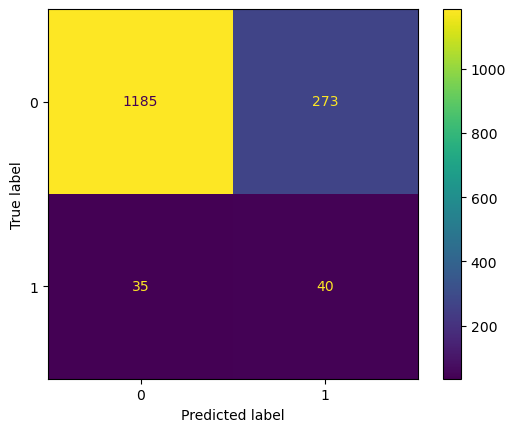

In [57]:
# Membuat dan menampilkan confusion matrix 
ConfusionMatrixDisplay.from_estimator(pipe_knn, X_test, y_test)

## SVM

In [58]:
pipe_svc

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hypertension',
                                                   'heart_disease',
                                                   'ever_married'])])),
                ('smote',
                 SMOTENC(categorical_features=[3, 4, 5], random_state=20)),
                ('classifier', SVC())])

In [59]:
# Melatih model SVC
pipe_svc.fit(X_train, y_train)
print('Training Score:  ', round(pipe_svc.score(X_train,y_train),4))
print('Testing Score:  ', round(pipe_svc.score(X_test,y_test),4))

Training Score:   0.7134
Testing Score:   0.7143


In [60]:
# Melakukan prediksi menggunakan model SVC
y_train_predict_svc = pipe_svc.predict(X_train)
y_test_predict_svc = pipe_svc.predict(X_test)

In [61]:
# Menampilkan laporan klasifikasi model SVC
print('------Clasification Report SVC Train-------')
print(classification_report(y_train,y_train_predict_svc))

print('')
print('------Clasification Report SVC Test-------')
print(classification_report(y_test,y_test_predict_svc))



------Clasification Report SVC Train-------
              precision    recall  f1-score   support

           0       0.99      0.71      0.82      3402
           1       0.13      0.83      0.22       174

    accuracy                           0.71      3576
   macro avg       0.56      0.77      0.52      3576
weighted avg       0.95      0.71      0.80      3576


------Clasification Report SVC Test-------
              precision    recall  f1-score   support

           0       0.99      0.71      0.83      1458
           1       0.12      0.80      0.22        75

    accuracy                           0.71      1533
   macro avg       0.55      0.75      0.52      1533
weighted avg       0.94      0.71      0.80      1533



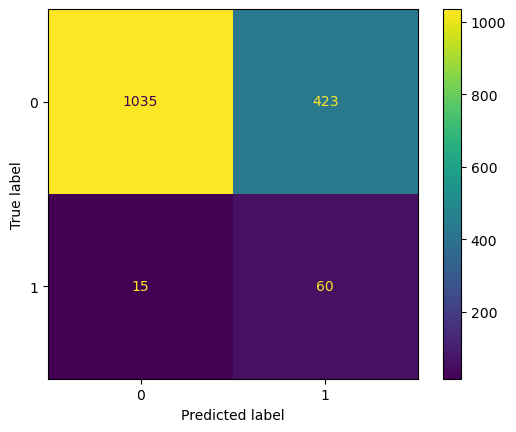

In [62]:
# Membuat dan menampilkan confusion matrix
ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test, y_test)

## Decision Tree

In [63]:
pipe_dt

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hypertension',
                                                   'heart_disease',
                                                   'ever_married'])])),
                ('smote',
                 SMOTENC(categorical_features=[3, 4, 5], random_state=20)),
                ('classifier', DecisionTreeClassifier())])

In [64]:
# Melatih model Decision Tree
pipe_dt.fit(X_train, y_train)
print('Training Score:  ', round(pipe_dt.score(X_train,y_train),4))
print('Testing Score:  ', round(pipe_dt.score(X_test,y_test),4))

Training Score:   0.9989
Testing Score:   0.8637


In [65]:
# Melakukan prediksi menggunakan model Decision Tree
y_train_predict_dt = pipe_dt.predict(X_train)
y_test_predict_dt = pipe_dt.predict(X_test)

In [66]:
# Menampilkan laporan klasifikasi model Decision Tree
print('------Clasification Report Decision Tree Train-------')
print(classification_report(y_train,y_train_predict_dt))

print('')
print('------Clasification Report Decision Tree Test-------')
print(classification_report(y_test,y_test_predict_dt))


------Clasification Report Decision Tree Train-------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3402
           1       1.00      0.98      0.99       174

    accuracy                           1.00      3576
   macro avg       1.00      0.99      0.99      3576
weighted avg       1.00      1.00      1.00      3576


------Clasification Report Decision Tree Test-------
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      1458
           1       0.08      0.17      0.11        75

    accuracy                           0.86      1533
   macro avg       0.52      0.54      0.52      1533
weighted avg       0.91      0.86      0.89      1533



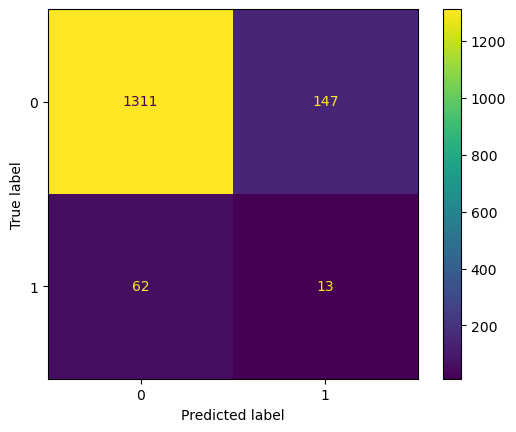

In [67]:
# Membuat dan menampilkan confusion matrix
ConfusionMatrixDisplay.from_estimator(pipe_dt, X_test, y_test)

## Random Forest

In [68]:
pipe_rf

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hypertension',
                                                   'heart_disease',
                                                   'ever_married'])])),
                ('smote',
                 SMOTENC(categorical_features=[3, 4, 5], random_state=20)),
                ('classifier', RandomForestClassifier())])

In [69]:
# Melatih model Random Forest
pipe_rf.fit(X_train, y_train)
print('Training Score:  ', round(pipe_rf.score(X_train,y_train),4))
print('Testing Score:  ', round(pipe_rf.score(X_test,y_test),4))

Training Score:   0.9989
Testing Score:   0.88


In [70]:
# Melakukan prediksi menggunakan model Random Forest
y_train_predict_rf = pipe_rf.predict(X_train)
y_test_predict_rf = pipe_rf.predict(X_test)

In [71]:
# Menampilkan laporan klasifikasi model Random Forest
print('------Clasification Report Random Forest Train-------')
print(classification_report(y_train,y_train_predict_rf))

print('')
print('------Clasification Report Random Forest Test-------')
print(classification_report(y_test,y_test_predict_rf))


------Clasification Report Random Forest Train-------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3402
           1       0.99      0.99      0.99       174

    accuracy                           1.00      3576
   macro avg       0.99      0.99      0.99      3576
weighted avg       1.00      1.00      1.00      3576


------Clasification Report Random Forest Test-------
              precision    recall  f1-score   support

           0       0.97      0.91      0.93      1458
           1       0.17      0.37      0.23        75

    accuracy                           0.88      1533
   macro avg       0.57      0.64      0.58      1533
weighted avg       0.93      0.88      0.90      1533



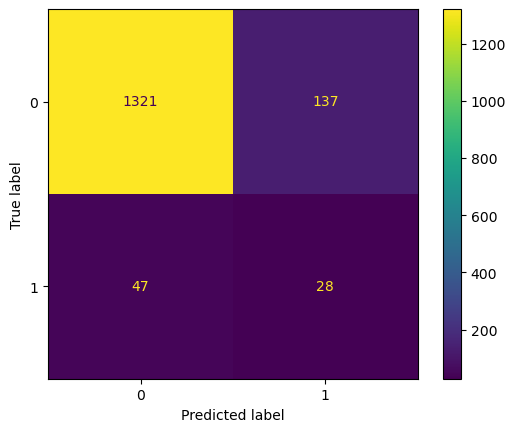

In [112]:
# Membuat dan menampilkan confusion matrix
ConfusionMatrixDisplay.from_estimator(pipe_rf, X_test, y_test)

## AdaBoost

In [72]:
pipe_ada

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hypertension',
                                                   'heart_disease',
                                                   'ever_married'])])),
                ('smote',
                 SMOTENC(categorical_features=[3, 4, 5], random_state=20)),
                ('classifier', AdaBoostClassifier())])

In [73]:
# Melatih model Ada Boost
pipe_ada.fit(X_train, y_train)
print('Training Score:  ', round(pipe_ada.score(X_train,y_train),4))
print('Testing Score:  ', round(pipe_ada.score(X_test,y_test),4))

Training Score:   0.7444
Testing Score:   0.7312


In [74]:
# Melakukan prediksi menggunakan model Ada Boost
y_train_predict_ada = pipe_ada.predict(X_train)
y_test_predict_ada = pipe_ada.predict(X_test)

In [75]:
# Menampilkan laporan klasifikasi model Ada Boost
print('------Clasification Report Ada Boost Train-------')
print(classification_report(y_train,y_train_predict_ada))

print('')
print('------Clasification Report Ada Boost Test-------')
print(classification_report(y_test,y_test_predict_ada))


------Clasification Report Ada Boost Train-------
              precision    recall  f1-score   support

           0       0.98      0.74      0.85      3402
           1       0.13      0.74      0.22       174

    accuracy                           0.74      3576
   macro avg       0.56      0.74      0.53      3576
weighted avg       0.94      0.74      0.82      3576


------Clasification Report Ada Boost Test-------
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1458
           1       0.12      0.71      0.20        75

    accuracy                           0.73      1533
   macro avg       0.55      0.72      0.52      1533
weighted avg       0.94      0.73      0.81      1533



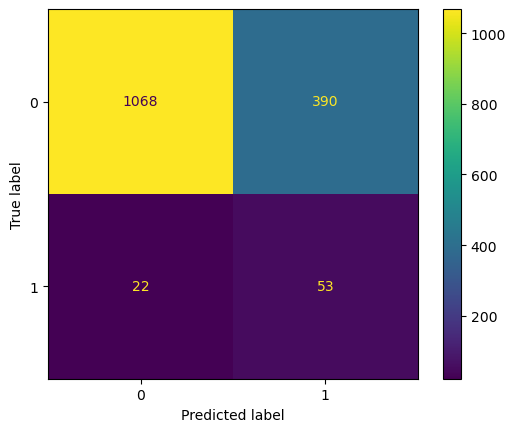

In [113]:
# Membuat dan menampilkan confusion matrix
ConfusionMatrixDisplay.from_estimator(pipe_ada, X_test, y_test)

## Cross Validation 

In [76]:
# Membuat fungsi untuk melakukan cross validation dan mengukur performa model dengan metrik recall
def cross_val (model):

    recall_train_cross_val = cross_val_score(model,
                                        X_train,
                                        y_train,
                                        cv=5,
                                        scoring="recall")

    print('----Cross Validation',model,'---- ')
    print('recall Score - All - Cross Validation  : ', recall_train_cross_val)
    print('recall Score - Mean - Cross Validation : ', recall_train_cross_val.mean())
    print('recall Score - Std - Cross Validation  : ', recall_train_cross_val.std())
    print('recall Score - Range of Test-Set       : ', (recall_train_cross_val.mean()-recall_train_cross_val.std()) , '-', (recall_train_cross_val.mean()+recall_train_cross_val.std()))

In [77]:
# Memanggil fungsi cross_val pada model KNN
cross_val(pipe_knn)

----Cross Validation Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknow

In [78]:
# Memanggil fungsi cross_val pada model SVC
cross_val(pipe_svc)

----Cross Validation Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknow

In [79]:
# Memanggil fungsi cross_val pada model Decision Tree
cross_val(pipe_dt)

----Cross Validation Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknow

In [80]:
# Memanggil fungsi cross_val pada model Random Forest
cross_val(pipe_rf)

----Cross Validation Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknow

In [81]:
# Memanggil fungsi cross_val pada model Ada Boost
cross_val(pipe_ada)

----Cross Validation Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknow

**INSIGHT:**

Dari hasil tersebut, `SVC` memiliki rata-rata recall yang tertinggi, dengan rentang yang cukup baik, sehingga dapat dijadikan pilihan yang kuat untuk memprediksi kelas positif dengan baik. Tetapi karena keterbatasan waktu saat hyperparameter tuning, saya memilih untuk menggunakan model `Ada Boost` yang merupakan model terbaik kedua.

## Hyperparameter Tuning 

In [83]:
# Definisikan grid parameter yang ingin dijelajahi
param_grid_ada = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 1.0],
    'classifier__base_estimator': [None, DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)]
}

In [84]:
# Membuat objek GridSearchCV
grid_search_ada = GridSearchCV(pipe_ada, param_grid_ada, cv=5, scoring='recall', n_jobs=-1)

In [85]:
# Melakukan penyetelan hyperparameter pada data pelatihan
grid_search_ada.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['age',
                                                                          'avg_glucose_level',
                                                                          'bmi']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['hypert...
                                                                          'ever_married'])])),
                                       ('smote',
                                        SMOTENC(categorical_features=[3, 4, 5],
                                                random_state=20)),
                                       ('classifier', AdaBoostClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__base_estimator': [None,
                                                        DecisionTreeClassifier(max_depth=1),
                                                        DecisionTreeClassifier(max_depth=2)],
                         'classifier__learning_rate': [0.01, 0.1, 1.0],
                         'classifier__n_estimators': [50, 100, 200]},
             scoring='recall')

In [86]:
# Menampilkan parameter terbaik
print("Parameter Terbaik:", grid_search_ada.best_params_)

# Mencetak skor terbaik
print("Skor Recall Terbaik:", grid_search_ada.best_score_)

Parameter Terbaik: {'classifier__base_estimator': None, 'classifier__learning_rate': 0.01, 'classifier__n_estimators': 50}
Skor Recall Terbaik: 0.8739495798319329


Setelah dilakukan hyperparameter tuning didapati bahwa parameter terbaik untuk Ada Boost adalah sebagai berikut : 
- 'base_estimatoe': None
- 'learning_rate': 0.01
- 'n_estimators': 50

In [87]:
# Mengambil model terbaik setelah dilakukan hyperparameter tuning dengan GridSearchCV pada model AdaBoost
model_ada_best = grid_search_ada.best_estimator_

In [88]:
# Melakukan prediksi pada model terbaik 
y_train_predict_ada_best = model_ada_best.predict(X_train)
y_test_predict_ada_best = model_ada_best.predict(X_test)

In [89]:
# Menampilkan laporan klasifikasi model terbaik Ada Boost
print('------Clasification Report Ada Boost Train-------')
print(classification_report(y_train, y_train_predict_ada_best))

print('')
print('------Clasification Report Ada Boost Test-------')
print(classification_report(y_test, y_test_predict_ada_best))

------Clasification Report Random Ada Boost Train-------
              precision    recall  f1-score   support

           0       0.99      0.68      0.80      3402
           1       0.12      0.84      0.21       174

    accuracy                           0.69      3576
   macro avg       0.55      0.76      0.51      3576
weighted avg       0.95      0.69      0.77      3576


------Clasification Report Random Ada Boost Test-------
              precision    recall  f1-score   support

           0       0.99      0.68      0.80      1458
           1       0.12      0.87      0.21        75

    accuracy                           0.69      1533
   macro avg       0.56      0.77      0.51      1533
weighted avg       0.95      0.69      0.78      1533



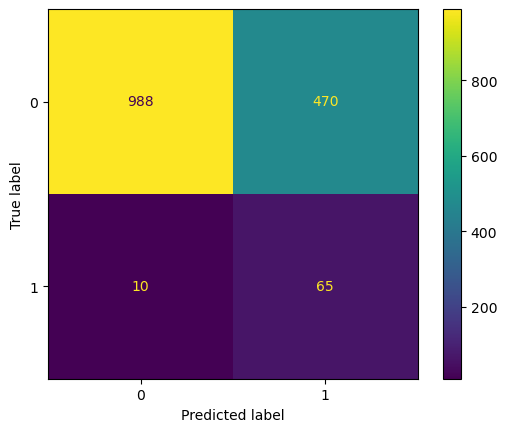

In [90]:
# Membuat dan menampilkan confusion matrix
ConfusionMatrixDisplay.from_estimator(model_ada_best, X_test, y_test)

In [91]:
# Membuat tabel baru default untuk nantinya membandingkan dengan nilai recall score test yang default dan yang sudah dengan menggunakan random seach
all_reports_ada_boost = {}
def performance_report(all_reports_ada_boost, y_train, y_train_predict_ada, y_test, y_test_predict_ada, name):
  score_reports = {
      'train - precision' : precision_score(y_train, y_train_predict_ada),
      'train - recall' : recall_score(y_train, y_train_predict_ada),
      'train - accuracy' : accuracy_score(y_train, y_train_predict_ada),
      'train - f1_score' : f1_score(y_train, y_train_predict_ada),
      'test - precision' : precision_score(y_test, y_test_predict_ada),
      'test - recall' : recall_score(y_test, y_test_predict_ada),
      'test - accuracy_score' : accuracy_score(y_test, y_test_predict_ada),
      'test - f1_score' : f1_score(y_test, y_test_predict_ada),
  }
  all_reports_ada_boost[name] = score_reports
  return all_reports_ada_boost

all_reports_ada_boost = performance_report(all_reports_ada_boost, y_train, y_train_predict_ada, y_test, y_test_predict_ada, 'Baseline (Default Hyperparameter)')
pd.DataFrame(all_reports_ada_boost)

all_reports_ada_boost = performance_report(all_reports_ada_boost, y_train, y_train_predict_ada_best, y_test, y_test_predict_ada_best, 'After HyperParameter Tuning')
pd.DataFrame(all_reports_ada_boost)

,Baseline (Default Hyperparameter),After HyperParameter Tuning
train - precision,0.128514,0.118167
train - recall,0.735632,0.844828
train - accuracy,0.744407,0.685682
train - f1_score,0.218803,0.207334
test - precision,0.119639,0.121495
test - recall,0.706667,0.866667
test - accuracy_score,0.731246,0.686888
test - f1_score,0.204633,0.213115


**INSIGHT:**

Dari hasil di atas, akan diambil model terbaik yaitu model `AdaBoost` setelah dilakukan hyperparameter tuning. Model ini hampir best fit, nilai dari recall pada train untuk Ada Boost ini adalah 0,84 sedangkan untuk test adalah 0,86. Dengan begitu model ini bisa dianggap best fit karena hanya memiliki selisih sedikit yaitu 0,02.

#  Model Saving

In [92]:
with open('best_model.pkl', 'wb') as file_1:
  pickle.dump(model_ada_best, file_1)

# Kesimpulan

1. Pada project ini, kolom yang memiliki korelasi dan yang dipakai dalam modeling adalah:
    - 'age'
    - 'avg_glucose_level'
    - 'bmi'
    - 'hypertension'
    - 'heart_disease'
    - 'ever_married'
    
.

2. Berdasarkan uji coba dan melakukan trial and error, dapat disimpulkan bahwa model yang terbaik adalah model SVC tetapi karena keterbatasan waktu saat hyperparameter tuning, saya memilih untuk mengambil model AdaBoost yang merupakan model terbaik kedua untuk menyelesaikan project ini. Model AdaBoost setelah dilakukan hyperparameter tuning yang digunakan pada project ini hampir best fit dikarenakan nilai recall pada data train dan data test hanya selisih 0,02. Dimana nilai recall pada data train adalah 0,84 sedangkan nilai recall pada data test adalah 0,86 dengan parameter terbaik nya sebagai berikut:
    - 'base_estimatoe': None
    - 'learning_rate': 0.01
    - 'n_estimators': 50

.

3. Kelebihan dan kekurangan dari model yang yang digunakan:
    - Kelebihan: Secara teori model Adaboost memiliki kinerja yang baik dalam tugas klasifikasi, dan ini dapat digunakan untuk mengidentifikasi faktor-faktor yang berkontribusi terhadap risiko stroke sehingga dapat membantu dalam pencegahan dan manajemen risiko.
    - Kekurangan: Sensitif terhadap perubahan data sehingga jika data medis berubah seiring waktu, model Adaboost mungkin perlu diperbarui secara berkala. Sensitivitas terhadap perubahan data dapat menjadi tantangan dalam konteks perawatan jangka panjang untuk pasien stroke.

.

4. Berdasarkan tingkat recall yang masih diangka 0,86 menandakan model ini belum bisa dikatakan model yang memprediksi secara akurat. Karena menurut saya model yang benar-benar bagus adalah model yang dapat menghasilan best score diatas 0,90 . Oleh karena itu kita bisa mengambil langkah-langkah seperti:
    - Mengumpulkan lebih banyak data pasien termasuk informasi lebih lanjut tentang riwayat medis, pola makan, aktivitas fisik, dan lain-lain yang dapat membuat memperkuat model. Dari data yang lebih lengkap bisa memberikan wawasan yang lebih baik lagi tentang faktor risiko stroke.
    - Melakukan feature engineering yang dapat membantu dalam mengindentifikasi fitur yang lebih kuat untuk prediksi stroke.

# Conceptual Problem

> **1. Jelaskan latar belakang adanya bagging dan cara kerja bagging !**

JAWAB: 

Bagging atau singkatan dari Bootstrap Aggregating adalah teknik yang digunakan dalam machine learning untuk mengatasi masalah overfitting dalam model prediksi. Bagging bekerja dengan mengambil sampel ulang data asli dengan pengulangan, menghasilkan kumpulan data bootstrap yang berbeda untuk setiap model. Setiap model kemudian dilatih pada kumpulan data bootstrapnya sendiri. Hasil prediksi dari setiap model kemudian digabungkan untuk menghasilkan prediksi akhir.
Cara kerja bagging adalah sebagai berikut:
Ambil sampel ulang data asli dengan pengulangan, menghasilkan kumpulan data bootstrap yang berbeda untuk setiap model.
Latih model pada kumpulan data bootstrapnya sendiri.
Gabungkan hasil prediksi dari setiap model untuk menghasilkan prediksi akhir.
Dengan melakukan ini, Bagging mengurangi varian model dan membantu menghasilkan model yang lebih stabil dan dapat diandalkan.

> **2. Jelaskan perbedaan cara kerja algoritma Random Forest dengan algoritma boosting yang Anda pilih !**

JAWAB:

Perbedaan utama antara random forest dan algoritma AdaBoost adalah pada cara kerja mereka.

Random forest bekerja dengan membangun beberapa decision tree dari kumpulan data yang sama. Setiap decision tree dibangun dengan menggunakan subset data dan subset fitur yang berbeda. Hal ini dilakukan untuk mengurangi korelasi antara decision tree yang berbeda, sehingga prediksi akhir menjadi lebih akurat.

Algoritma AdaBoost bekerja dengan membangun beberapa model dari data yang dimodifikasi dari model sebelumnya. Data yang dimodifikasi ini dirancang untuk memperkuat area yang diprediksi dengan buruk oleh model sebelumnya.

Perbedaan lain antara random forest dan algoritma AdaBoost adalah pada model dasar yang digunakan. Random forest menggunakan decision tree sebagai model dasarnya, sedangkan algoritma AdaBoost menggunakan model dasar yang sama untuk membangun beberapa model.

> **3. Jelaskan apa yang dimaksud dengan Cross Validation !**
Jelaskan apa yang dimaksud dengan Cross Validation !

JAWAB:

Cross Validation adaah teknik evaluasi model machine learning yang digunakan untuk memperkirakan akurasi model pada data baru. Cross validation bekerja dengan membagi dataset menjadi beberapa subset yang disebut lipatan (folds), biasanya dalam jumlah k tertentu. Kemudian, model dilatih pada beberapa fold dan diuji pada fold yang tersisa. Proses ini diulang beberapa kali, sehingga setiap fold akan digunakan sebagai data uji setidaknya sekali. Hasil pengujian dari setiap iterasi digabungkan dan dihitung metrik evaluasi seperti akurasi, recall, atau lainnya. Keuntungan Cross Validation adalah memberikan gambaran yang lebih baik tentang sejauh mana model Anda akan berkinerja di luar data pelatihan. Ini membantu mengidentifikasi overfitting atau bias dalam model. Ada beberapa jenis Cross Validation, salah satu nya adalah K-fold cross validation, dimana data train dibagi menjadi K fold. Model dilatih pada K-1 fold dan diuji pada fold yang tersisa. Proses ini diulang K kali. Cross validation adalah teknik yang penting untuk digunakan dalam machine learning. Cross validation membantu memastikan bahwa model yang dilatih memiliki akurasi yang baik pada data baru.